# Imports

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"]   = "1"

!pip install -q segmentation-models-pytorch==0.3.3
!pip install -q albumentations==1.4.7 lpips torch-fidelity

import json, random, cv2, numpy as np, matplotlib.pyplot as plt
import shutil, zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from google.colab import drive
from tqdm import tqdm
import random
import albumentations as A
import math
from pathlib import Path
from matplotlib import cm
import re
import gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
zip_path = "archive.zip"

if os.path.exists(zip_path):
    os.remove(zip_path)

gdown.download(id="1_HPn3NogV4NPD88i1Y9jDgUbr-dQKuHS", output=zip_path, quiet=False)

os.makedirs("datasets", exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("datasets")

print("\n")

for root, dirs, files in os.walk("datasets"):
    print(root,len(files))

print("✅ Dataset downloaded succesfully!")

Downloading...
From (original): https://drive.google.com/uc?id=1_HPn3NogV4NPD88i1Y9jDgUbr-dQKuHS
From (redirected): https://drive.google.com/uc?id=1_HPn3NogV4NPD88i1Y9jDgUbr-dQKuHS&confirm=t&uuid=05877989-d8e0-41fd-bf76-39fd878bbd8e
To: /content/archive.zip
100%|██████████| 4.45G/4.45G [00:35<00:00, 127MB/s]




datasets 0
datasets/Teeth Segmentation PNG 1
datasets/Teeth Segmentation PNG/d2 0
datasets/Teeth Segmentation PNG/d2/masks_machine 598
datasets/Teeth Segmentation PNG/d2/ann 598
datasets/Teeth Segmentation PNG/d2/img 598
datasets/Teeth Segmentation PNG/d2/masks_human 598
datasets/Teeth Segmentation JSON 2
datasets/Teeth Segmentation JSON/d2 0
datasets/Teeth Segmentation JSON/d2/masks_machine 598
datasets/Teeth Segmentation JSON/d2/ann 598
datasets/Teeth Segmentation JSON/d2/img 598
datasets/Teeth Segmentation JSON/d2/masks_human 598
✅ Dataset downloaded succesfully!


In [ ]:
# PASTE THE LINK COPIED IN THE PREVIOUS CODE HERE
PUBLIC_URL = "https://files.catbox.moe/v55u9l.zip"

TARGET_DIR = "/content/synthetic_img"
ZIP_PATH   = "/content/synthetic_img.zip"

!wget -O {ZIP_PATH} "{PUBLIC_URL}"

if os.path.exists(TARGET_DIR):
    shutil.rmtree(TARGET_DIR)
os.makedirs(TARGET_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(TARGET_DIR)

print("✅ Dataset ready in:", TARGET_DIR)
!ls -lh {TARGET_DIR} | head -n 2

--2025-09-07 10:05:04--  https://files.catbox.moe/v55u9l.zip
Resolving files.catbox.moe (files.catbox.moe)... 108.181.20.35
Connecting to files.catbox.moe (files.catbox.moe)|108.181.20.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9473966 (9.0M) [application/zip]
Saving to: ‘/content/synthetic_img.zip’

/content/synthetic_ 100%[===================>]   9.03M  3.55MB/s    in 2.5s    

2025-09-07 10:05:07 (3.55 MB/s) - ‘/content/synthetic_img.zip’ saved [9473966/9473966]

✅ Dataset ready in: /content/synthetic_img
total 9.5M
-rw-r--r-- 1 root root 47K Sep  7 10:05 102.png


# Globals

In [ ]:
# Editable parameters
EPOCHS = 100
IMG_SIZE = 256
BATCH_SIZE = 8

DATA_MODE     = "mix"            # "real" | "syn" | "mix"
MIX_STRATEGY  = "replace"        # "concat" | "replace" | "ratio"
SYN_RATIO     = 0.3

DATA_MODE_VAL = "mix"            # "real" | "syn" | "mix"
MIX_STRATEGY_VAL = "ratio"       # "concat" | "replace" | "ratio"

In [ ]:
# Path dataset
ROOT = "/content/datasets/Teeth Segmentation JSON/d2"
IMG_DIR = os.path.join(ROOT, "img")
HUM_DIR = os.path.join(ROOT, "masks_human")
ANN_DIR = os.path.join(ROOT, "masks_human")
META_PATH = "/content/datasets/Teeth Segmentation JSON/meta.json"
MAP_PATH  = "/content/datasets/Teeth Segmentation JSON/obj_class_to_machine_color.json"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fixed parameters
NUM_WORKERS = 2
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
IGNORE_INDEX = 255

SYN_DIR = globals().get("TARGET_DIR", None)
ANN_DIR = globals().get("ANN_DIR", None)

NUM_CLASSES = 33  # 32 teeth + background
BG_ID = 0

IMG_EXTS = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}
SUFFS = ['_img','-img','_image','-image','_mask','-mask','_seg','-seg','_label','-label']
EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

# Utils

In [ ]:
def list_files(d):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    return sorted([f for f in os.listdir(d) if f.lower().endswith(exts)])

def to_map(dirpath):
    return {os.path.splitext(f)[0]: os.path.join(dirpath, f) for f in list_files(dirpath)}


def key_from_json_filename(fn: str) -> str:
    # "5.jpg.json" -> "5"
    base = os.path.basename(fn)
    if base.lower().endswith(".json"):
        base = base[:-5]
    base, _ = os.path.splitext(base)
    return base


def safe_hex_to_rgb(h: str):
    h = (h or "#FFFFFF").strip().lstrip("#")
    if len(h) == 3: h = "".join([c*2 for c in h])
    h = h.ljust(6, "0")[:6]
    return tuple(int(h[i:i+2], 16) for i in (0,2,4))


def colorize_idx(idx_map: np.ndarray, ignore_index: int = IGNORE_INDEX) -> np.ndarray:
    vis = idx_map.astype(np.int32).copy()
    vis[vis == ignore_index] = 0
    return palette[vis]


def stems_set(d):
    d = Path(d)
    return {q.stem for q in d.iterdir() if q.is_file() and q.suffix.lower() in EXTS}

def normk(s: str):
    s = Path(s).stem.strip().lower()
    for suf in SUFFS:
        if s.endswith(suf):
            s = s[:-len(suf)]
    if s.isdigit():
        s = str(int(s))
    return s

SUFFS = ['_img','-img','_image','-image','_mask','-mask','_seg','-seg','_label','-label']
def norm(k: str):
    s = Path(k).stem.strip().lower()
    for suf in SUFFS:
        if s.endswith(suf):
            s = s[:-len(suf)]
    if s.isdigit():
        s = str(int(s))
    return s

def idx_norm(m):
    out = {}
    for k,p in m.items():
        nk = norm(k)
        if nk not in out: out[nk] = p
    return out


def norm_key(name: str):
    s = Path(name).name.strip().lower()
    while True:
        root, ext = os.path.splitext(s)
        if ext.lower() == ".json" or ext.lower() in IMG_EXTS:
            s = root
            continue
        break
    for suf in SUFFS:
        if s.endswith(suf): s = s[:-len(suf)]
    if s.isdigit(): s = str(int(s))
    return s


# index JSON
json_idx = {}
for fn in os.listdir(ANN_DIR):
    if fn.lower().endswith(".json"):
        json_idx[norm_key(fn)] = os.path.join(ANN_DIR, fn)

# find couples synth+json
synth_paths = [p for p in Path(SYN_DIR).iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
pairs = []
for p in synth_paths:
    nk = norm_key(p.stem)
    jp = json_idx.get(nk)
    if jp: pairs.append((str(p), jp, p.stem))

def idx_color_bgr(i):
    r,g,b,_ = cm.tab20(i % 20)
    return (int(b*255), int(g*255), int(r*255))


In [ ]:
def rasterize_any(json_path, out_shape_hw):
    Ht, Wt = out_shape_hw
    with open(json_path, "r") as f:
        d = json.load(f)

    # A) LabelMe
    if "shapes" in d:
        Hs = d.get("imageHeight", Ht); Ws = d.get("imageWidth", Wt)
        sx, sy = Wt/float(Ws), Ht/float(Hs)
        m = np.zeros((Ht, Wt), np.uint8)
        for s in d["shapes"]:
            pts = s.get("points", [])
            if len(pts) >= 3:
                poly = np.array([[int(round(x*sx)), int(round(y*sy))] for x,y in pts], np.int32)
                cv2.fillPoly(m, [poly], 255)
        return m

    # B) Supervisely
    objs = d.get("objects") or d.get("labels")
    if objs is not None:
        Hs = (d.get("size", {}) or {}).get("height") or d.get("imgHeight") or Ht
        Ws = (d.get("size", {}) or {}).get("width")  or d.get("imgWidth")  or Wt
        sx, sy = Wt/float(Ws), Ht/float(Hs)
        m = np.zeros((Ht, Wt), np.uint8)
        for obj in objs:
            pts = None
            if "points" in obj and "exterior" in obj["points"]:
                pts = obj["points"]["exterior"]
            elif "geometry" in obj and "points" in obj["geometry"] and "exterior" in obj["geometry"]["points"]:
                pts = obj["geometry"]["points"]["exterior"]
            if not pts: continue
            poly = np.array([[int(round(x*sx)), int(round(y*sy))] for x,y in pts], np.int32)
            if poly.shape[0] >= 3:
                cv2.fillPoly(m, [poly], 255)
        return m
    return np.zeros((Ht, Wt), np.uint8)

def map_title_to_idx(title: str) -> int | None:
    t = str(title).strip()
    return TITLE2IDX.get(t, None)


def rasterize_labels_33_meta(json_path: str, out_shape_hw: tuple[int,int]) -> np.ndarray:
    H, W = out_shape_hw
    with open(json_path, "r") as f:
        d = json.load(f)

    lab = np.full((H, W), BG_ID, np.uint8)

    # LabelMe
    if "shapes" in d:
        Hs = d.get("imageHeight", H); Ws = d.get("imageWidth", W)
        sx, sy = W/float(Ws), H/float(Hs)
        for s in d["shapes"]:
            cid = map_title_to_idx(s.get("label", ""))
            if cid is None:
                continue
            pts = s.get("points", [])
            if len(pts) < 3:
                continue
            poly = np.array([[int(round(x*sx)), int(round(y*sy))] for x,y in pts], np.int32)
            cv2.fillPoly(lab, [poly], int(cid))
        return lab

    # Supervisely
    objs = d.get("objects") or d.get("labels")
    if objs is not None:
        Hs = (d.get("size", {}) or {}).get("height") or d.get("imgHeight") or H
        Ws = (d.get("size", {}) or {}).get("width")  or d.get("imgWidth")  or W
        sx, sy = W/float(Ws), H/float(Hs)
        for obj in objs:
            cid = map_title_to_idx(obj.get("classTitle", ""))
            if cid is None:
                continue
            # punti
            pts = None
            if "points" in obj and "exterior" in obj["points"]:
                pts = obj["points"]["exterior"]
            elif "geometry" in obj and "points" in obj["geometry"] and "exterior" in obj["geometry"]["points"]:
                pts = obj["geometry"]["points"]["exterior"]
            if not pts:
                continue
            poly = np.array([[int(round(x*sx)), int(round(y*sy))] for x,y in pts], np.int32)
            cv2.fillPoly(lab, [poly], int(cid))
        return lab

    return lab

# Data

In [ ]:
# pair synth+json
synth_paths = [p for p in Path(SYN_DIR).iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
pairs = []
for p in synth_paths:
    nk = norm_key(p.stem)
    jp = json_idx.get(nk)
    if jp: pairs.append((str(p), jp, p.stem))
print(f"Couples found: {len(pairs)}/{len(synth_paths)} (SYN='{SYN_DIR}', ANN='{ANN_DIR}')")

# Meta & palette
with open(META_PATH, "r") as f:
    meta = json.load(f)

# Take only the 32 teeth
classes_raw = [c for c in meta["classes"] if str(c.get("title","")).isdigit()]
classes_sorted = sorted(classes_raw, key=lambda c: int(c["title"]))

CLASS_TITLES = [c["title"] for c in classes_sorted]
TITLE2IDX    = {t: i+1 for i,t in enumerate(CLASS_TITLES)}
IDX2TITLE    = {v:k for k,v in TITLE2IDX.items()}
N_CLASSES    = 1 + len(CLASS_TITLES)

# Palette RGB to visualize (0=black)
palette = np.zeros((N_CLASSES, 3), dtype=np.uint8)
for c in classes_sorted:
    idx = TITLE2IDX[c["title"]]
    palette[idx] = np.array(safe_hex_to_rgb(c.get("color","#FFFFFF")), dtype=np.uint8)


Couples found: 0/200 (SYN='/content/synthetic_img', ANN='/content/datasets/Teeth Segmentation JSON/d2/masks_human')


In [ ]:
# raw maps reconstruction
ANN_DIR = os.path.join(ROOT, "ann")
json_map_raw = {}
for fn in os.listdir(ANN_DIR):
    if fn.lower().endswith(".json"):
        k = key_from_json_filename(fn)
        json_map_raw[k] = os.path.join(ANN_DIR, fn)

img_map_raw  = to_map(IMG_DIR)
syn_map_raw  = to_map(TARGET_DIR)


img_idx  = idx_norm(img_map_raw)
syn_idx  = idx_norm(syn_map_raw)
json_idx = idx_norm(json_map_raw)

real_keys = sorted(set(img_idx)  & set(json_idx))
syn_keys  = sorted(set(syn_idx)  & set(json_idx))

img_map   = {k: img_idx[k]   for k in real_keys}
json_map  = {k: json_idx[k]  for k in real_keys}
syn_img_map = {k: syn_idx[k] for k in syn_keys}

print(f"Real usable (img∩json): {len(real_keys)}  | Synth usable (syn∩json): {len(syn_keys)}")

Real usable (img∩json): 598  | Synth usable (syn∩json): 200


# Network

In [ ]:
SYN_DIR  = "/content/synthetic_img"
REAL_DIR = IMG_DIR

# stem computation
st_syn  = stems_set(SYN_DIR)
st_real = stems_set(REAL_DIR)

# intersection
common = sorted(st_syn & st_real)

print(f"✔️ Found {len(common)} matched samples (img ↔ ann). Example: {common[0] if common else 'None'}")

train_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2(transpose_mask=True)
])

val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_NEAREST),
    ToTensorV2(transpose_mask=True)
])

✔️ Found 200 matched samples (img ↔ ann). Example: 102


In [ ]:
class TeethSegDataset(Dataset):

    def __init__(
        self,
        *,
        real_img_map: dict,
        real_json_map: dict,
        syn_img_map: dict = None,
        syn_json_map: dict = None,
        mode: str = "real",
        mix_strategy: str = "concat",
        syn_ratio: float = 0.5,
        transform=None
    ):
        self.real_img_map = real_img_map or {}
        self.real_json_map = real_json_map or {}
        self.syn_img_map = syn_img_map or {}
        self.syn_json_map = syn_json_map
        self.mode = mode
        self.mix_strategy = mix_strategy
        self.syn_ratio = float(syn_ratio)
        self.transform = transform
        self.keys_real = list(self.real_img_map.keys())
        self.keys_syn  = list(self.syn_img_map.keys())

        if mode == "real":
            self.index = [("real", k) for k in self.keys_real]

        elif mode == "syn":
            if not self.keys_syn:
                raise ValueError("mode='syn' ma syn_img_map è vuoto.")
            self.index = [("syn", k) for k in self.keys_syn]

        elif mode == "mix":
            if not self.keys_syn:
                raise ValueError("mode='mix' ma syn_img_map è vuoto.")
            if mix_strategy == "concat":
                self.index = [("real", k) for k in self.keys_real] + [("syn", k) for k in self.keys_syn]

            elif mix_strategy == "replace":
                self.index = []
                for k in self.keys_real:
                    src = "syn" if k in self.syn_img_map else "real"
                    self.index.append((src, k))

            elif mix_strategy == "ratio":
                self.L = max(len(self.keys_real), len(self.keys_syn))
                self.index = None
            else:
                raise ValueError("mix_strategy has to be in {'concat','replace','ratio'}")
        else:
            raise ValueError("mode has to be in {'real','syn','mix'}")

    def __len__(self):
        if self.mode == "mix" and self.mix_strategy == "ratio":
            return self.L
        return len(self.index)

    def _load_pair(self, src, k):
        if src == "real":
            img_p = self.real_img_map[k]
            json_p = self.real_json_map[k]
        else:
            img_p = self.syn_img_map[k]
            if self.syn_json_map and (k in self.syn_json_map):
                json_p = self.syn_json_map[k]
            else:
                if k not in self.real_json_map:
                    raise KeyError(f"Missing target for the synthetic key '{k}'.")
                json_p = self.real_json_map[k]
        img = cv2.imread(img_p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(img_p)
        target = target = rasterize_labels_33_meta(json_p, img.shape)
        return img, target

    def __getitem__(self, idx):
        if self.mode == "mix" and self.mix_strategy == "ratio":
            use_syn = (random.random() < self.syn_ratio)
            if use_syn:
                k = random.choice(self.keys_syn)
                src = "syn"
            else:
                k = random.choice(self.keys_real)
                src = "real"
        else:
            src, k = self.index[idx]

        img, target = self._load_pair(src, k)

        # Albumentations
        img_np = img[:, :, None]
        if self.transform:
            aug = self.transform(image=img_np, mask=target)
            x = aug["image"]
            y = aug["mask"].long()
        else:
            x = torch.from_numpy(img_np.transpose(2,0,1)).float() / 255.0
            y = torch.from_numpy(target).long()

        return x, y, k

# Train

In [ ]:
random.seed(42)
random.shuffle(common)
val_ratio = 0.2
val_count = max(1, int(len(common) * val_ratio))
val_keys = sorted(common[:val_count])
train_keys = [k for k in common if k not in val_keys]
print(f"Train: {len(train_keys)} | Val: {len(val_keys)}")

Train: 160 | Val: 40


In [ ]:
n_val     = max(1, int(round(len(real_keys) * val_ratio)))
val_keys  = set(random.sample(real_keys, n_val))
train_keys_real = [k for k in real_keys if k not in val_keys]

train_keys_syn = [k for k in syn_keys if k in train_keys_real]
val_keys_syn   = [k for k in syn_keys if k in val_keys]

# safety: disjointed splits
assert set(train_keys_real).isdisjoint(val_keys), "Leak between train and val (REAL)!"
assert set(train_keys_syn).isdisjoint(set(val_keys_syn)), "Leak between train and val (SYN)!"

real_img_map_train  = {k: img_map[k]   for k in train_keys_real}
real_json_map_train = {k: json_map[k]  for k in train_keys_real}
syn_img_map_train   = {k: syn_img_map[k] for k in train_keys_syn}

real_img_map_val    = {k: img_map[k]   for k in val_keys}
real_json_map_val   = {k: json_map[k]  for k in val_keys}
syn_img_map_val     = {k: syn_img_map[k] for k in val_keys_syn}


train_ds = TeethSegDataset(
    real_img_map = real_img_map_train,
    real_json_map= real_json_map_train,
    syn_img_map  = syn_img_map_train,
    syn_json_map = None,
    mode         = DATA_MODE,
    mix_strategy = MIX_STRATEGY,
    syn_ratio    = 0.5,
    transform    = train_tf
)

val_ds = TeethSegDataset(
    real_img_map = real_img_map_val,
    real_json_map= real_json_map_val,
    syn_img_map  = syn_img_map_val,
    syn_json_map = None,
    mode         = DATA_MODE_VAL,
    mix_strategy = MIX_STRATEGY_VAL,
    syn_ratio    = 0.5,
    transform    = val_tf
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_pin = (device.type == "cuda")


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=_pin, drop_last=True,
                          persistent_workers=(NUM_WORKERS > 0))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=_pin,
                          persistent_workers=(NUM_WORKERS > 0))


NR_tr = len(train_keys_real)
NS_tr_rep = len([k for k in train_keys_real if k in train_keys_syn])
LEN_tr = len(train_ds)

NR_val = len(val_keys)
NS_val = len(val_keys_syn)
LEN_val = len(val_ds)

print(f"Train (mix/replace): total={LEN_tr} | real_kept={NR_tr-NS_tr_rep} | synth_replaced={NS_tr_rep}")
print(f"Val   (mix/concat) : total={LEN_val} | real={NR_val} | synth={NS_val}")

# Sanity check labels [0..32]
xb, yb, *_ = next(iter(train_loader))
print("xb:", xb.shape, xb.dtype, float(xb.min()), float(xb.max()))
print("yb:", yb.shape, yb.dtype, int(yb.min()), int(yb.max()))
print("yb unique (head):", torch.unique(yb)[:20].tolist())

assert yb.dtype == torch.long
assert int(yb.min()) >= 0 and int(yb.max()) < N_CLASSES, "Label out of range [0..32]"

Train (mix/replace): total=478 | real_kept=316 | synth_replaced=162
Val   (mix/concat) : total=120 | real=120 | synth=38
xb: torch.Size([8, 1, 256, 256]) torch.uint8 0.0 255.0
yb: torch.Size([8, 256, 256]) torch.int64 0 32
yb unique (head): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
# First model: Mobile U-net

class ConvBNReLU(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_in, c_out, k, s, p, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class PatchEmbed(nn.Module):
    def __init__(self, in_ch, embed_dim, patch_size=16):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.proj(x)
        B, D, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        return x, (H, W)

class PositionalEncoding2D(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.row_embed = nn.Parameter(torch.randn(1, 512, embed_dim // 2))
        self.col_embed = nn.Parameter(torch.randn(1, 512, embed_dim // 2))
    def forward(self, B, H, W, device, dtype):
        row = self.row_embed[:, :H, :]
        col = self.col_embed[:, :W, :]
        pos = torch.cat([
            row.unsqueeze(2).expand(1, H, W, -1),
            col.unsqueeze(1).expand(1, H, W, -1)
        ], dim=-1)
        pos = pos.reshape(1, H*W, -1).to(device=device, dtype=dtype)
        return pos.expand(B, -1, -1)

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=256, depth=4, num_heads=8, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(depth):
            self.layers.append(nn.ModuleDict({
                "ln1": nn.LayerNorm(embed_dim),
                "attn": nn.MultiheadAttention(embed_dim, num_heads, dropout=drop, batch_first=True),
                "ln2": nn.LayerNorm(embed_dim),
                "mlp": nn.Sequential(
                    nn.Linear(embed_dim, int(embed_dim*mlp_ratio)),
                    nn.GELU(),
                    nn.Dropout(drop),
                    nn.Linear(int(embed_dim*mlp_ratio), embed_dim),
                ),
            }))
    def forward(self, x):
        for blk in self.layers:
            h = blk["ln1"](x)
            attn_out, _ = blk["attn"](h, h, h, need_weights=False)
            x = x + attn_out
            h = blk["ln2"](x)
            x = x + blk["mlp"](h)
        return x

class UpBlock(nn.Module):
    def __init__(self, c_in, c_skip, c_out):
        super().__init__()
        self.conv1 = ConvBNReLU(c_in + c_skip, c_out)
        self.conv2 = ConvBNReLU(c_out, c_out)
    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

def _pad_to_multiple(x, mult=16):
    B,C,H,W = x.shape
    pad_h = (mult - H % mult) % mult
    pad_w = (mult - W % mult) % mult
    if pad_h or pad_w:
        x = F.pad(x, (0, pad_w, 0, pad_h))
    return x, (H, W), (pad_h, pad_w)

def _unpad(x, orig_hw, pad_hw):
    H0, W0 = orig_hw
    if x.shape[-2:] != (H0, W0):
        x = x[..., :H0, :W0]
    return x

# Second model: Trans U-net

class TransUNet(nn.Module):

    def __init__(self, in_channels=1, num_classes=2, base_ch=32, embed_dim=256,
                 patch_size=16, depth=4, num_heads=8, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        self.patch_size = patch_size

        # Encoder
        self.enc1 = nn.Sequential(
            ConvBNReLU(in_channels, base_ch),
            ConvBNReLU(base_ch, base_ch),
        )
        self.down1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            ConvBNReLU(base_ch, base_ch*2),
            ConvBNReLU(base_ch*2, base_ch*2),
        )
        self.down2 = nn.MaxPool2d(2)

        self.enc3 = nn.Sequential(
            ConvBNReLU(base_ch*2, base_ch*4),
            ConvBNReLU(base_ch*4, base_ch*4),
        )

        self.conv_to_embed = nn.Conv2d(base_ch*4, embed_dim, kernel_size=1, bias=False)

        self.patch_embed = PatchEmbed(embed_dim, embed_dim, patch_size=patch_size)
        self.pos = PositionalEncoding2D(embed_dim)
        self.tr = TransformerEncoder(embed_dim=embed_dim, depth=depth,
                                     num_heads=num_heads, mlp_ratio=mlp_ratio, drop=drop)

        # Decoder
        self.dec3 = UpBlock(embed_dim, base_ch*4, base_ch*4)
        self.dec2 = UpBlock(base_ch*4, base_ch*2, base_ch*2)
        self.dec1 = UpBlock(base_ch*2, base_ch,   base_ch)

        self.head = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def forward(self, x):
        x, orig_hw, pad_hw = _pad_to_multiple(x, mult=self.patch_size)

        # Encoder
        s1 = self.enc1(x)
        x  = self.down1(s1)
        s2 = self.enc2(x)
        x  = self.down2(s2)
        s3 = self.enc3(x)

        # to embedding space
        feat = self.conv_to_embed(s3) # (B, D, H/4, W/4)

        # patchify + positional + transformer
        tokens, (h_p, w_p) = self.patch_embed(feat)
        pos = self.pos(tokens.shape[0], h_p, w_p, tokens.device, tokens.dtype)
        tokens = tokens + pos
        tokens = self.tr(tokens)

        # unpatchify
        B, N, D = tokens.shape
        feat_tr = tokens.transpose(1, 2).reshape(B, D, h_p, w_p)

        # Decoder with skip
        x = self.dec3(feat_tr, s3)
        x = self.dec2(x,      s2)
        x = self.dec1(x,      s1)
        logits = self.head(x)
        logits = _unpad(logits, orig_hw, pad_hw)
        return logits

In [ ]:
def compute_class_weights(loader, n_classes, bg_weight=0.2, power=0.5):
    hist = torch.zeros(n_classes, dtype=torch.long)
    for _, y, _ in loader:
        y = y.view(-1)
        hist += torch.bincount(y, minlength=n_classes)
    freq = (hist.float() / hist.sum().clamp_min(1)).clamp_min(1e-6)
    w = (1.0 / freq)**power
    w = w / w.mean()
    w[0] = bg_weight
    return w

def make_warmup_cosine(optimizer, epochs, warmup_epochs=3):
    def lr_lambda(e):
        if e < warmup_epochs:
            return (e + 1) / float(warmup_epochs)
        t = (e - warmup_epochs) / max(1, (epochs - warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * t))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def _confmat_update(cm, preds, targets, n_classes):
    preds   = preds.view(-1).to(torch.int64)
    targets = targets.view(-1).to(torch.int64)
    k = (targets >= 0) & (targets < n_classes)
    inds = n_classes * targets[k] + preds[k]
    cm += torch.bincount(inds, minlength=n_classes**2).reshape(n_classes, n_classes)
    return cm

@torch.no_grad()
def compute_metrics(model, loader, criterion, device, n_classes):
    model.eval()
    val_loss_acc = 0.0
    cm = torch.zeros((n_classes, n_classes), dtype=torch.long, device=device)
    for imgs, masks, _ in loader:
        imgs  = imgs.to(device, dtype=torch.float32)
        masks = masks.to(device)
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            logits = model(imgs)
            val_loss_acc += criterion(logits, masks).item()
        preds = logits.argmax(1)
        cm = _confmat_update(cm, preds, masks, n_classes)

    tp = cm.diag().to(torch.float32)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    denom_iou  = (tp + fp + fn).clamp_min(1e-9)
    denom_dice = (2*tp + fp + fn).clamp_min(1e-9)
    iou_per_class  = (tp / denom_iou).detach().cpu().numpy()
    dice_per_class = (2*tp / denom_dice).detach().cpu().numpy()
    return {
        "val_loss": val_loss_acc/len(loader),
        "mIoU": float(iou_per_class.mean()),
        "mDice": float(dice_per_class.mean()),
        "IoU_per_class": iou_per_class,
        "Dice_per_class": dice_per_class,
    }


def make_warmup_cosine(optimizer, epochs, warmup_epochs=3):
    import math
    def lr_lambda(e):
        if e < warmup_epochs:
            return (e + 1) / float(warmup_epochs)
        t = (e - warmup_epochs) / max(1, (epochs - warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * t))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def train_one_model(
    model,
    train_loader,
    val_loader,
    criterion,
    *,
    name="model",
    epochs=10,
    lr=1e-3,
    weight_decay=1e-4,
    tmax=5,
    patience=5,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    n_classes=None,

    scheduler_kind: str = "cosine",
    warmup_epochs: int = 3,
    enable_clip: bool = False,
    clip_max_norm: float = 1.0,
):
    assert n_classes is not None, "Passa n_classes=N_CLASSES per calcolare le metriche."

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    if scheduler_kind == "warmup_cosine":
        scheduler = make_warmup_cosine(optimizer, epochs=epochs, warmup_epochs=warmup_epochs)
    else:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=tmax)

    use_amp = (device.type == "cuda")
    scaler  = torch.amp.GradScaler('cuda', enabled=use_amp)

    best_val = float("inf"); best_epoch = -1; wait = 0

    for epoch in range(1, epochs+1):
        model.train()
        train_loss_acc = 0.0

        for imgs, masks, _ in tqdm(train_loader, desc=f"[{name}] Epoch {epoch}/{epochs}", leave=False):
            imgs  = imgs.to(device, dtype=torch.float32)
            masks = masks.to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=use_amp):
                logits = model(imgs)
                loss   = criterion(logits, masks)

            scaler.scale(loss).backward()
            if enable_clip:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
            scaler.step(optimizer)
            scaler.update()

            train_loss_acc += loss.item()

        scheduler.step()

        if epoch % 3 == 0:
            val_pack = compute_metrics(model, val_loader, criterion, device, n_classes)
            val_loss = val_pack["val_loss"]
            print(f"[{name}] Epoch {epoch} | Train L:{train_loss_acc/len(train_loader):.4f} | "
                  f"Val L:{val_loss:.4f} | mIoU:{val_pack['mIoU']:.4f} | mDice:{val_pack['mDice']:.4f}")

            if val_loss < best_val:
                best_val, best_epoch, wait = val_loss, epoch, 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"⏹️  [{name}] Early stopping @ epoch {epoch} (best {best_epoch})")
                    break

    final_metrics = compute_metrics(model, val_loader, criterion, device, n_classes)
    print(f"🧩 [{name}] Best @ epoch {best_epoch} | best_val_loss={best_val:.4f} | "
          f"mIoU={final_metrics['mIoU']:.4f} | mDice={final_metrics['mDice']:.4f}")

    return {
        "name": name,
        "best_epoch": best_epoch,
        "best_val_loss": best_val,
        "metrics": final_metrics,
    }

#  TransUNet training parameters
LR_TR  = 5e-4
WD_TR  = 5e-2
CLIP_N = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss
class_w = compute_class_weights(train_loader, N_CLASSES)
class_w = class_w.to(device)

# New loss: weighted CE + smoothing + Dice
ce_loss   = nn.CrossEntropyLoss(weight=class_w, label_smoothing=0.05)
dice_loss = smp.losses.DiceLoss(mode="multiclass")
def criterion(logits, targets):
    return ce_loss(logits, targets) + dice_loss(logits, targets)


# Training
best_val, best_epoch, wait, patience = float("inf"), -1, 0, 2

In [ ]:
#U-net
cnn = smp.Unet("mobilenet_v2", encoder_weights="imagenet", in_channels=1, classes=N_CLASSES).to(device)
results_cnn = train_one_model(cnn, train_loader, val_loader, criterion,
                          name="unet_mobilenetv2", epochs=EPOCHS, n_classes=N_CLASSES)
#Trans U-net
tr = TransUNet(
    in_channels=1,
    num_classes=N_CLASSES,
    base_ch=32,
    embed_dim=256,
    patch_size=16,
    depth=6,
    num_heads=8,
    mlp_ratio=4.0,
    drop=0.1
).to(device)


results_tr = train_one_model(
    tr, train_loader, val_loader, criterion,
    name="transunet",
    epochs=EPOCHS, n_classes=N_CLASSES,
    lr=5e-4, weight_decay=5e-2,
    scheduler_kind="warmup_cosine",
    warmup_epochs=3,
    enable_clip=True, clip_max_norm=1.0
)

[unet_mobilenetv2] Epoch 3 | Train L:2.6566 | Val L:2.7294 | mIoU:0.1894 | mDice:0.2878


[unet_mobilenetv2] Epoch 6 | Train L:2.4206 | Val L:2.4038 | mIoU:0.3337 | mDice:0.4831


[unet_mobilenetv2] Epoch 9 | Train L:2.2956 | Val L:2.2742 | mIoU:0.3684 | mDice:0.5268


[unet_mobilenetv2] Epoch 12 | Train L:2.1060 | Val L:2.1882 | mIoU:0.4090 | mDice:0.5697


[unet_mobilenetv2] Epoch 15 | Train L:1.9558 | Val L:1.9617 | mIoU:0.5240 | mDice:0.6822


[unet_mobilenetv2] Epoch 18 | Train L:1.9791 | Val L:1.9688 | mIoU:0.5225 | mDice:0.6812


[unet_mobilenetv2] Epoch 21 | Train L:2.0297 | Val L:2.1261 | mIoU:0.4284 | mDice:0.5831


[unet_mobilenetv2] Epoch 24 | Train L:1.9048 | Val L:1.8411 | mIoU:0.5734 | mDice:0.7241


[unet_mobilenetv2] Epoch 27 | Train L:1.8465 | Val L:1.8875 | mIoU:0.5503 | mDice:0.7036


[unet_mobilenetv2] Epoch 30 | Train L:1.9270 | Val L:2.2166 | mIoU:0.3951 | mDice:0.5534


[unet_mobilenetv2] Epoch 33 | Train L:1.8683 | Val L:1.9336 | mIoU:0.5266 | mDice:0.6857


[unet_mobilenetv2] Epoch 36 | Train L:1.7846 | Val L:1.8492 | mIoU:0.5607 | mDice:0.7140


[unet_mobilenetv2] Epoch 39 | Train L:1.8457 | Val L:1.9075 | mIoU:0.5423 | mDice:0.6983
⏹️  [unet_mobilenetv2] Early stopping @ epoch 39 (best 24)
🧩 [unet_mobilenetv2] Best @ epoch 24 | best_val_loss=1.8411 | mIoU=0.5387 | mDice=0.6939


[transunet] Epoch 3 | Train L:3.5270 | Val L:3.2055 | mIoU:0.2589 | mDice:0.3893


[transunet] Epoch 6 | Train L:2.5266 | Val L:2.4479 | mIoU:0.3206 | mDice:0.4719


[transunet] Epoch 9 | Train L:2.2186 | Val L:2.1730 | mIoU:0.4083 | mDice:0.5717


[transunet] Epoch 12 | Train L:2.1014 | Val L:2.0777 | mIoU:0.4411 | mDice:0.6060


[transunet] Epoch 15 | Train L:2.0150 | Val L:2.0148 | mIoU:0.4483 | mDice:0.6092


[transunet] Epoch 18 | Train L:1.9518 | Val L:1.9134 | mIoU:0.5347 | mDice:0.6920


[transunet] Epoch 21 | Train L:1.9528 | Val L:1.9703 | mIoU:0.5032 | mDice:0.6631


[transunet] Epoch 24 | Train L:1.8892 | Val L:1.9835 | mIoU:0.4903 | mDice:0.6495


[transunet] Epoch 27 | Train L:1.8489 | Val L:1.9124 | mIoU:0.5132 | mDice:0.6725


[transunet] Epoch 30 | Train L:1.8239 | Val L:1.9061 | mIoU:0.5297 | mDice:0.6878


[transunet] Epoch 33 | Train L:1.8040 | Val L:1.8883 | mIoU:0.5396 | mDice:0.6937


[transunet] Epoch 36 | Train L:1.7697 | Val L:1.8303 | mIoU:0.5821 | mDice:0.7316


[transunet] Epoch 39 | Train L:1.7431 | Val L:1.9474 | mIoU:0.5188 | mDice:0.6773


[transunet] Epoch 42 | Train L:1.7338 | Val L:1.9517 | mIoU:0.5283 | mDice:0.6870


[transunet] Epoch 45 | Train L:1.7117 | Val L:1.8234 | mIoU:0.5814 | mDice:0.7312


[transunet] Epoch 48 | Train L:1.6837 | Val L:1.9348 | mIoU:0.5081 | mDice:0.6676


[transunet] Epoch 51 | Train L:1.6714 | Val L:1.8695 | mIoU:0.5514 | mDice:0.7058


[transunet] Epoch 54 | Train L:1.6544 | Val L:1.8480 | mIoU:0.5707 | mDice:0.7226


[transunet] Epoch 57 | Train L:1.6390 | Val L:1.9245 | mIoU:0.5303 | mDice:0.6882


[transunet] Epoch 60 | Train L:1.6239 | Val L:1.8656 | mIoU:0.5578 | mDice:0.7117
⏹️  [transunet] Early stopping @ epoch 60 (best 45)
🧩 [transunet] Best @ epoch 45 | best_val_loss=1.8234 | mIoU=0.5574 | mDice=0.7116


# Evaluation

In [ ]:
def save_predictions(
    model,
    loader,
    palette,
    out_dir,
    device,
    use_amp=True,
    suffix="pred"
):

    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    with torch.no_grad():
        for imgs, masks, keys in tqdm(loader, desc=f"Saving predictions [{suffix}]"):
            imgs = imgs.to(device, dtype=torch.float32)
            with torch.amp.autocast('cuda', enabled=(device.type=="cuda" and use_amp)):
                logits = model(imgs)
                pred_idx = torch.softmax(logits, 1).argmax(1)

            pred_idx = pred_idx.cpu().numpy().astype(np.uint8)
            for i, k in enumerate(keys):
                color_mask = palette[pred_idx[i]]
                cv2.imwrite(os.path.join(out_dir, f"{k}_{suffix}_color.png"),
                            cv2.cvtColor(color_mask, cv2.COLOR_RGB2BGR))
                cv2.imwrite(os.path.join(out_dir, f"{k}_{suffix}_idx.png"), pred_idx[i])

In [ ]:
save_predictions(
    cnn, val_loader, palette,
    out_dir=os.path.join(ROOT, "predictions_unet"),
    device=device,
    suffix="unet"
)

save_predictions(
    tr, val_loader, palette,
    out_dir=os.path.join(ROOT, "predictions_transunet"),
    device=device,
    suffix="transunet"
)

Saving predictions [transunet]: 100%|██████████| 15/15 [00:01<00:00, 10.14it/s]


In [ ]:

def visualize_models_comparison_rows(
    model_A_name, model_A,
    model_B_name, model_B,
    loader,
    *,
    max_rows=6
):

    device = next(model_A.parameters()).device
    use_amp = (device.type == "cuda")

    def colorize_idx(idx_map):
        vis = idx_map.astype(np.int32).copy()
        if 'IGNORE_INDEX' in globals() and IGNORE_INDEX is not None:
            vis[vis == IGNORE_INDEX] = 0
        return palette[vis]

    def to_vis_gray(t: torch.Tensor) -> np.ndarray:
        arr = t.detach().cpu().float()
        if arr.ndim == 3 and arr.shape[0] == 1:
            arr = arr[0]
        mn, mx = float(arr.min()), float(arr.max())
        if mx > mn:
            arr = (arr - mn) / (mx - mn)
        else:
            arr = torch.zeros_like(arr)
        return arr.numpy()

    def sample_metrics(gt_np, pr_np):
        ious, dices = [], []
        for c in range(1, N_CLASSES):
            gt_c = (gt_np == c); pr_c = (pr_np == c)
            gs, ps = int(gt_c.sum()), int(pr_c.sum())
            if gs == 0 and ps == 0:
                continue
            inter = int((gt_c & pr_c).sum())
            union = gs + ps - inter
            ious.append((inter+1e-6)/(union+1e-6))
            dices.append((2*inter+1e-6)/(gs+ps+1e-6))
        miou  = float(np.mean(ious))  if ious  else 0.0
        mdice = float(np.mean(dices)) if dices else 0.0
        return mdice, miou

    model_A.eval(); model_B.eval()
    shown = 0

    with torch.no_grad():
        for imgs, masks, keys in loader:
            if shown >= max_rows: break
            imgs  = imgs.to(device, dtype=torch.float32)
            masks = masks.to(device)

            with torch.amp.autocast('cuda', enabled=use_amp):
                preds_A = torch.softmax(model_A(imgs), 1).argmax(1)
                preds_B = torch.softmax(model_B(imgs), 1).argmax(1)

            for i in range(imgs.size(0)):
                if shown >= max_rows: break

                img_vis = to_vis_gray(imgs[i])
                gt_np   = masks[i].cpu().numpy()
                prA_np  = preds_A[i].cpu().numpy()
                prB_np  = preds_B[i].cpu().numpy()

                mdice_A, miou_A = sample_metrics(gt_np, prA_np)
                mdice_B, miou_B = sample_metrics(gt_np, prB_np)

                gt_rgb  = colorize_idx(gt_np)
                prA_rgb = colorize_idx(prA_np)
                prB_rgb = colorize_idx(prB_np)

                fig, axes = plt.subplots(1, 6, figsize=(20, 4))
                title = (f"{keys[i]}  |  "
                         f"[{model_A_name}] mDice:{mdice_A:.3f} mIoU:{miou_A:.3f}   |   "
                         f"[{model_B_name}] mDice:{mdice_B:.3f} mIoU:{miou_B:.3f}")
                fig.suptitle(title, y=0.94, fontsize=11)

                # columns
                axes[0].imshow(img_vis, cmap="gray"); axes[0].set_title("X-ray", fontsize=9); axes[0].axis("off")
                axes[1].imshow(gt_rgb); axes[1].set_title("Mask (GT)", fontsize=9); axes[1].axis("off")
                axes[2].imshow(prA_rgb); axes[2].set_title(f"{model_A_name} (pred)", fontsize=9); axes[2].axis("off")
                axes[3].imshow(prB_rgb); axes[3].set_title(f"{model_B_name} (pred)", fontsize=9); axes[3].axis("off")
                axes[4].imshow(img_vis, cmap="gray"); axes[4].imshow(prA_rgb, alpha=0.35)
                axes[4].set_title(f"Overlay {model_A_name}", fontsize=9); axes[4].axis("off")
                axes[5].imshow(img_vis, cmap="gray"); axes[5].imshow(prB_rgb, alpha=0.35)
                axes[5].set_title(f"Overlay {model_B_name}", fontsize=9); axes[5].axis("off")

                plt.subplots_adjust(top=0.82, wspace=0.1)
                fig.subplots_adjust(bottom=0.05)
                fig.add_artist(plt.Line2D([0, 1], [0.02, 0.02], color="black", linewidth=1, transform=fig.transFigure))

                plt.show()
                shown += 1

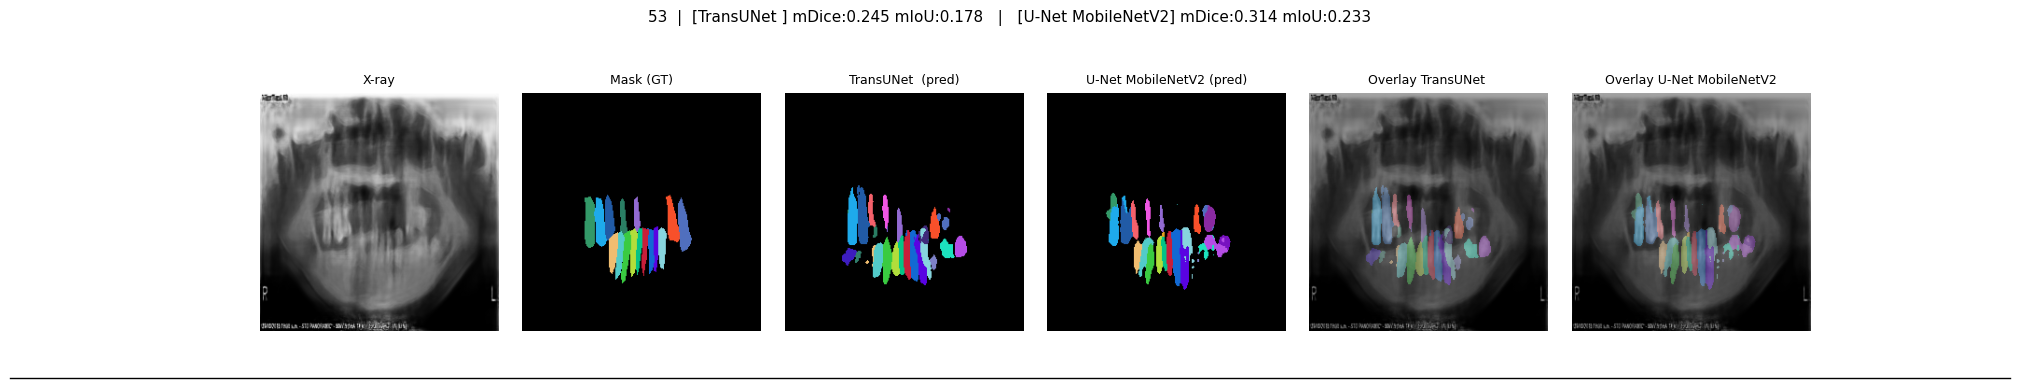

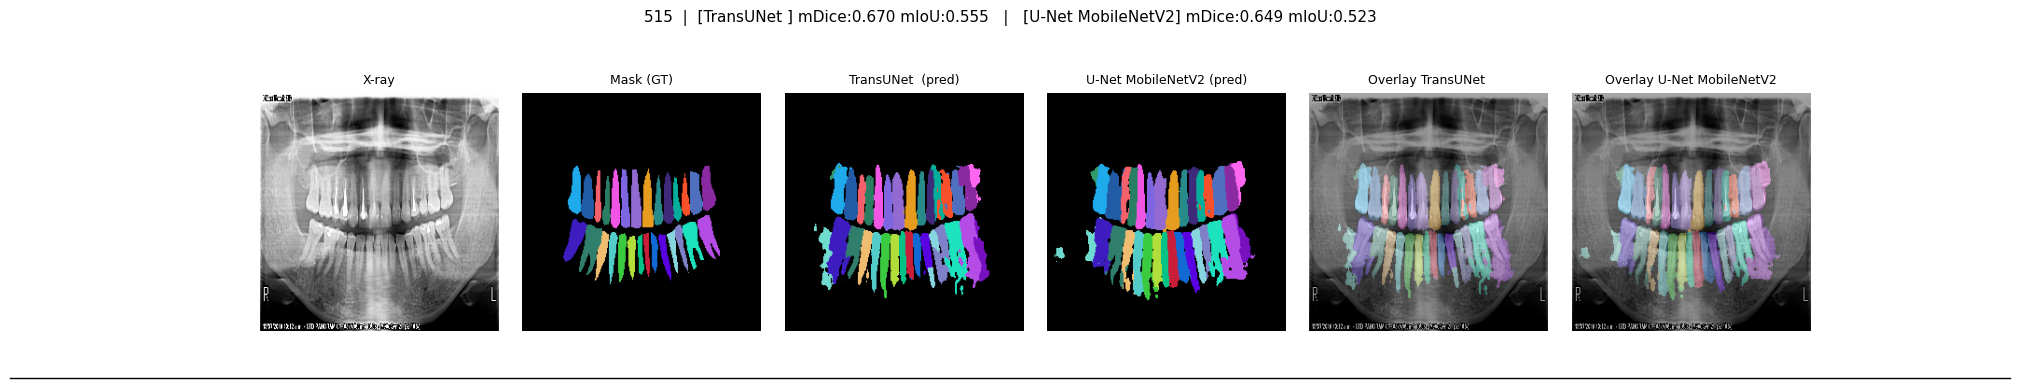

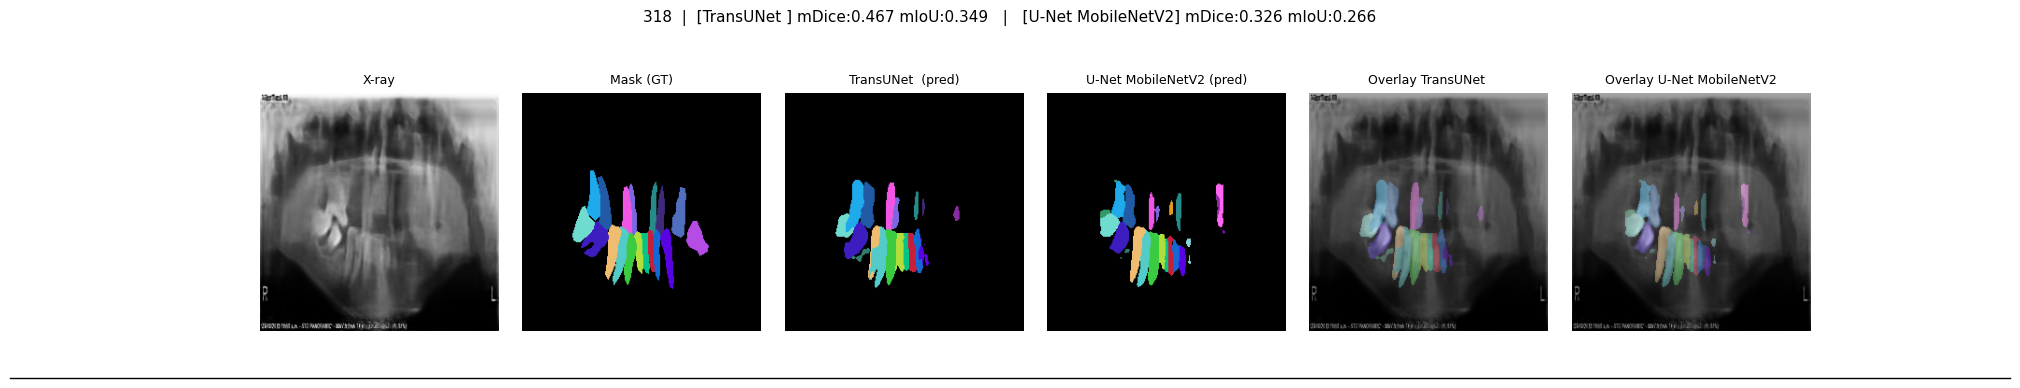

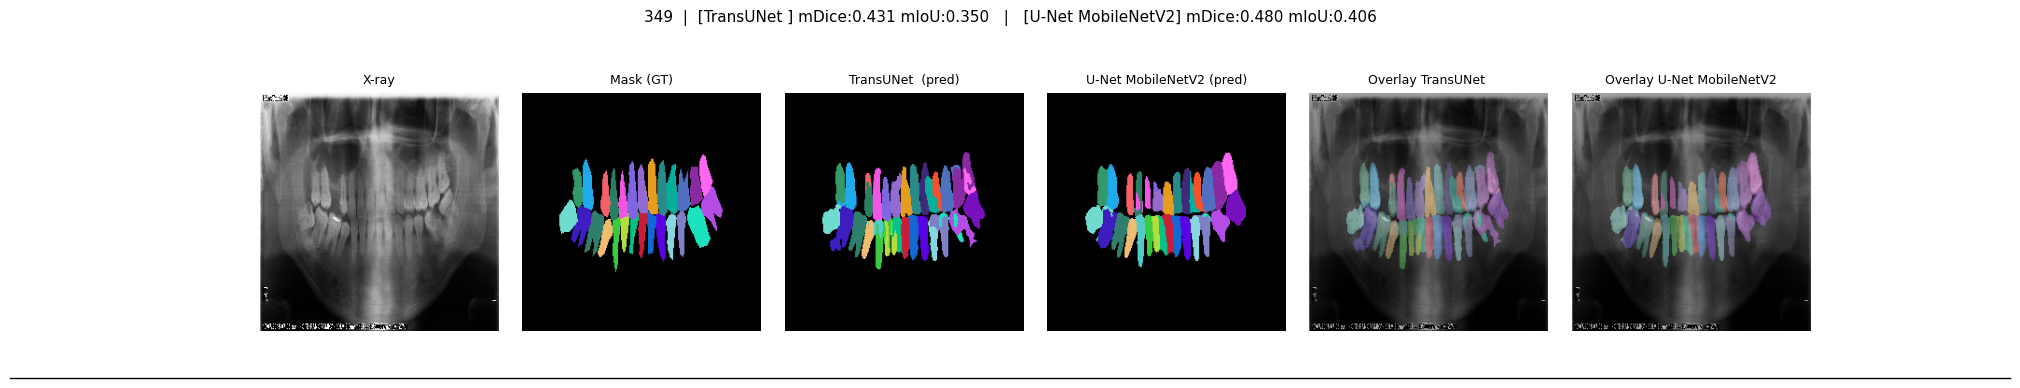

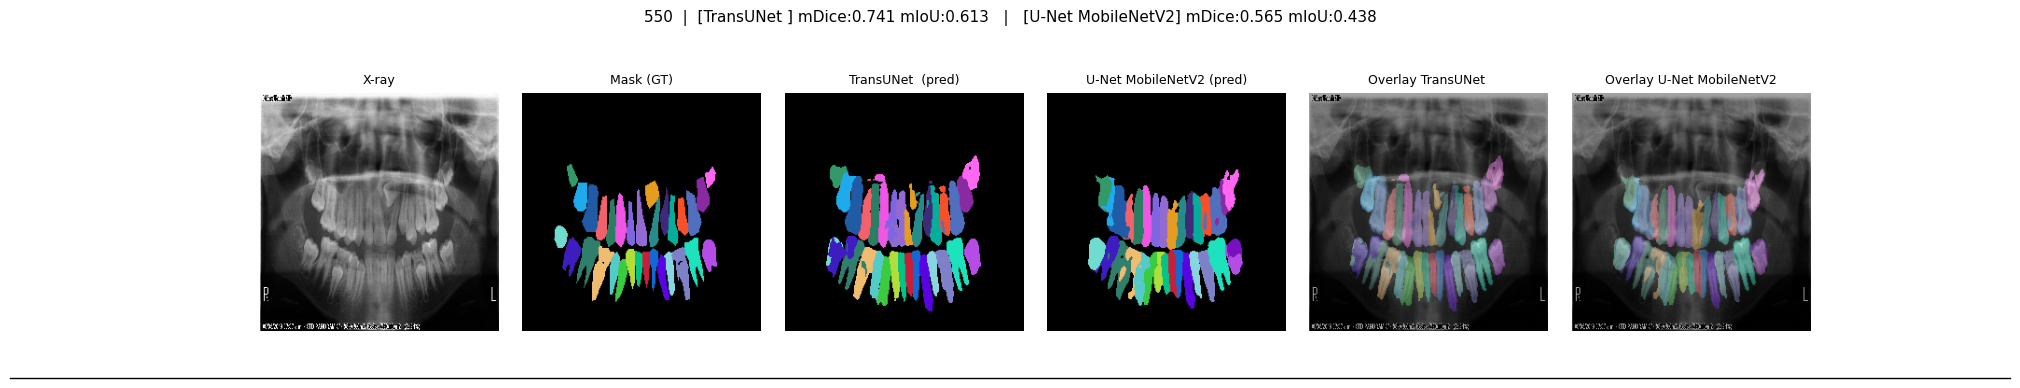

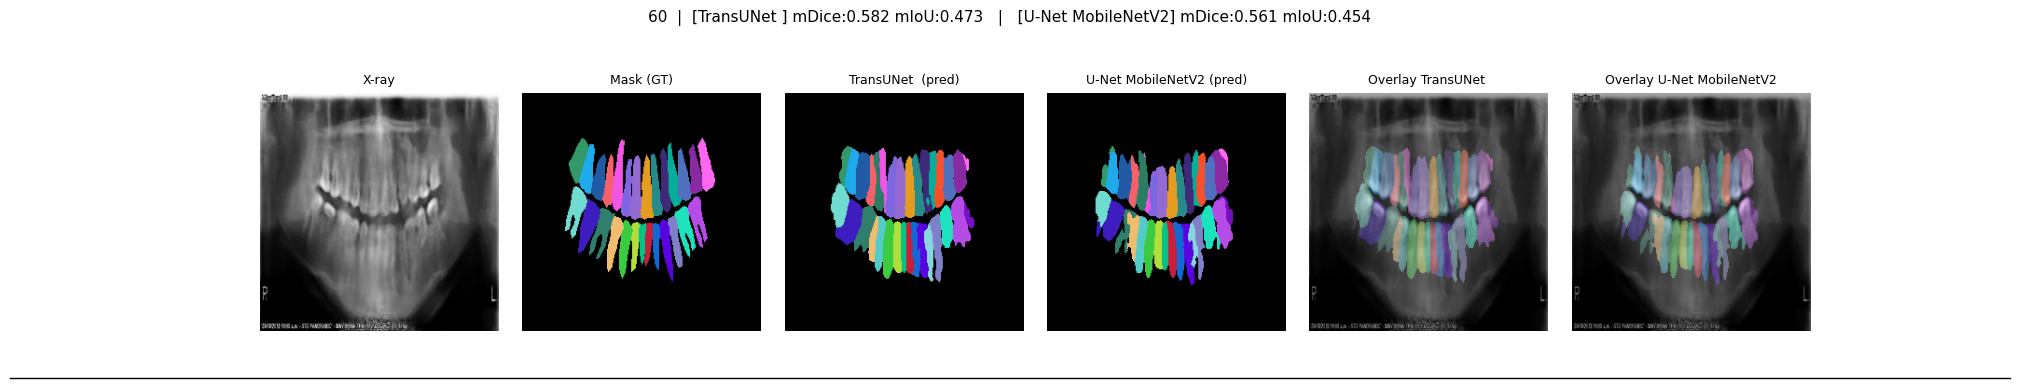

In [ ]:
visualize_models_comparison_rows(
    model_A_name="TransUNet ", model_A=tr,
    model_B_name="U-Net MobileNetV2", model_B=cnn,
    loader=val_loader,
    max_rows=6
)

In [ ]:
# Results in a .txt file
import datetime

def _maybe(n,d=None): return globals().get(n,d)
def _fmt(x, nd=4): return "N/A" if x is None else (f"{x:.{nd}f}" if isinstance(x,(int,float)) else str(x))

def _extract_or_compute(run, model, name):
    if isinstance(run, dict) and "metrics" in run:
        m = run["metrics"]
        return {
            "name": name,
            "best_epoch": run.get("best_epoch"),
            "best_val_loss": run.get("best_val_loss"),
            "mIoU": m.get("mIoU"),
            "mDice": m.get("mDice"),
            "IoU_per_class": m.get("IoU_per_class"),
            "Dice_per_class": m.get("Dice_per_class"),
        }

    cmf = _maybe("compute_metrics")
    if (model is not None) and (cmf is not None) and _maybe("val_loader") is not None:
        met = cmf(model, _maybe("val_loader"), _maybe("criterion"), _maybe("device"), _maybe("N_CLASSES"))
        return {
            "name": name,
            "best_epoch": None,
            "best_val_loss": float(met.get("val_loss")),
            "mIoU": float(met.get("mIoU")),
            "mDice": float(met.get("mDice")),
            "IoU_per_class": met.get("IoU_per_class"),
            "Dice_per_class": met.get("Dice_per_class"),
        }
    return None

def _fmt_table(iou_arr, dice_arr, class_titles=None):
    if iou_arr is None or dice_arr is None: return ["  (per-class metrics not available)"]
    K = max(len(iou_arr), len(dice_arr))
    lines = ["  idx  title  IoU      Dice","  ---- ------ -------- --------"]
    for c in range(K):
        title = "bg" if c==0 else (str(class_titles[c-1]) if class_titles and 0 <= c-1 < len(class_titles) else "-")
        iou  = _fmt(iou_arr[c])  if c < len(iou_arr)  else "N/A"
        dice = _fmt(dice_arr[c]) if c < len(dice_arr) else "N/A"
        lines.append(f"  {c:>3}  {title:>5}  {iou:>8} {dice:>8}")
    return lines

# dataset and setup
CLASS_TITLES = _maybe("CLASS_TITLES", [str(i) for i in range(1, _maybe("N_CLASSES",1))])
setup_lines = []
setup_lines.append("DATASET")
setup_lines.append(f"  IMG_SIZE        : {_fmt(_maybe('IMG_SIZE'))}")
setup_lines.append(f"  N_CLASSES       : {_fmt(_maybe('N_CLASSES'))}")
setup_lines.append(f"  SPLIT (val)     : {_fmt(_maybe('val_ratio'))}")
setup_lines.append(f"  TRAIN  real/syn : {len(_maybe('real_img_map_train',{}))} / {len(_maybe('syn_img_map_train',{}))}")
setup_lines.append(f"  VAL    real/syn : {len(_maybe('real_img_map_val',{}))} / {len(_maybe('syn_img_map_val',{}))}")
setup_lines.append("")
setup_lines.append("SETUP")
setup_lines.append(f"  BATCH_SIZE      : {_fmt(_maybe('BATCH_SIZE'))}")
setup_lines.append(f"  NUM_WORKERS     : {_fmt(_maybe('NUM_WORKERS'))}")
setup_lines.append(f"  EPOCHS          : {_fmt(_maybe('EPOCHS'))}")
lr = _maybe('LR'); wd = _maybe('WEIGHT_DECAY')
if lr is None and 'optimizer' in globals(): lr = globals()['optimizer'].param_groups[0].get('lr')
if wd is None and 'optimizer' in globals(): wd = globals()['optimizer'].param_groups[0].get('weight_decay')
tmax = _maybe('T_MAX');
if tmax is None and _maybe('scheduler') is not None: tmax = getattr(_maybe('scheduler'), 'T_max', None)
setup_lines.append(f"  LR / WD / T_MAX : {_fmt(lr)} / {_fmt(wd)} / {_fmt(tmax)}")
setup_lines.append(f"  AMP             : {_fmt(_maybe('use_amp'))}")
setup_lines.append(f"  DATA_MODE       : {_fmt(_maybe('DATA_MODE'))}  |  MIX_STRATEGY: {_fmt(_maybe('MIX_STRATEGY'))}")
setup_lines.append(f"  DATA_MODE_VAL   : {_fmt(_maybe('DATA_MODE_VAL'))}  |  MIX_STRATEGY_VAL: {_fmt(_maybe('MIX_STRATEGY_VAL'))}")
setup_lines.append(f"  SYN_RATIO       : {_fmt(_maybe('SYN_RATIO'))}")


unet  = _extract_or_compute(_maybe("results_cnn"), _maybe("cnn"), "unet_mobilenetv2")
trans = _extract_or_compute(_maybe("results_tr"),  _maybe("tr"),  "transunet")

def _score(d):
    if not d: return -1.0
    return (d.get("mDice") if d.get("mDice") is not None else d.get("mIoU", -1.0)) or -1.0

best = max([x for x in [unet, trans] if x], key=_score, default=None)


now = datetime.datetime.now()
fname = f"RESULTS_{now.strftime('%Y%m%d_%H%M')}_{DATA_MODE}.txt"

lines = [f"RESULTS — {now.strftime('%Y-%m-%d %H:%M:%S')}",
         "="*64] + setup_lines + ["-"]

def _block(d, title):
    if not d: return [f"{title}: N/A"]
    out = [
        f"{title}",
        f"  best_epoch     : {_fmt(d['best_epoch'])}",
        f"  best_val_loss  : {_fmt(d['best_val_loss'])}",
        f"  mIoU           : {_fmt(d['mIoU'])}",
        f"  mDice          : {_fmt(d['mDice'])}",
        f"  per-class:",
    ]
    out += _fmt_table(d.get("IoU_per_class"), d.get("Dice_per_class"), CLASS_TITLES)
    return out

lines += _block(unet, "UNet")
lines.append("-")
lines += _block(trans, "TransUNet")
lines.append("-")
lines.append(f"BEST (by mDice→mIoU): {best['name']} — mDice={_fmt(best.get('mDice'))}  mIoU={_fmt(best.get('mIoU'))}" if best else "BEST: N/A")
lines.append("="*64)

with open(fname, "w") as f:
    f.write("\n".join(lines))

print(f"✅ Saved {fname}\n")
print("\n".join(lines[:16]), "\n...\n", "\n".join(lines[-8:]), sep="")

✅ Saved RESULTS_20250907_1038_mix.txt

RESULTS — 2025-09-07 10:38:31
DATASET
  IMG_SIZE        : 256.0000
  N_CLASSES       : 33.0000
  SPLIT (val)     : 0.2000
  TRAIN  real/syn : 478 / 162
  VAL    real/syn : 120 / 38

SETUP
  BATCH_SIZE      : 8.0000
  NUM_WORKERS     : 2.0000
  EPOCHS          : 100.0000
  LR / WD / T_MAX : N/A / N/A / N/A
  AMP             : N/A
  DATA_MODE       : mix  |  MIX_STRATEGY: replace
...
   28     28  0.5905999 0.7426128
   29     29  0.6298273 0.77287614
   30     30  0.6264633 0.77033806
   31     31  0.5170523 0.6816539
   32     32  0.50208575 0.6685181
-
BEST (by mDice→mIoU): transunet — mDice=0.7116  mIoU=0.5574
